## Comparación
### Ignacio Castro
### Sergio Pacheco

In [1]:
#Ignorar advertencias
import warnings
warnings.filterwarnings("ignore")

### Cargar regresión logistica y random forest

In [2]:
from spacy.lang.es import Spanish
import seaborn as sns
from nltk.corpus import stopwords
# Puntuacion
punctuations = [".",",","!","?", ")","(","#","&"," ", ":", "'", "$", "/",'"', "}","{", ";"]

# Stopwords
stop_words=set(stopwords.words('spanish')) 

# Tokenizer
parser = Spanish()

def spacy_tokenizer(sentence):
    mytokens = parser(sentence)

    mytokens = [word.lower_ for word in mytokens]
        
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]

    return mytokens

In [3]:
#Vectorizar
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

bow_vector = CountVectorizer(tokenizer = spacy_tokenizer, ngram_range=(1,1))
tfidf_vector = TfidfVectorizer(tokenizer = spacy_tokenizer, ngram_range=(1,1))

In [4]:
import pickle

#Modelos similares a los V2 pero entrenados con el mismo split que la CNN para que sean más comparables.
RF_BOW = 'ICSP-RF-BOW-V3'
RF_IDF = 'ICSP-RF-IDF-V3'
RL_BOW = 'ICSP-RL-BOW-V3'
RL_IDF = 'ICSP-RL-IDF-V3'

RF_BOW = open(RF_BOW, 'rb')
RF_IDF = open(RF_IDF, 'rb')
RL_BOW = open(RL_BOW, 'rb')
RL_IDF = open(RL_IDF, 'rb')

model_RF_BOW = pickle.load(RF_BOW)
model_RF_IDF = pickle.load(RF_IDF)
model_RL_BOW = pickle.load(RL_BOW)
model_RL_IDF = pickle.load(RL_IDF)

RF_BOW.close()
RF_IDF.close()
RL_BOW.close()
RL_IDF.close()

In [5]:
from sklearn import preprocessing 
import pandas as pd
from pandasql import sqldf

label_encoder = preprocessing.LabelEncoder() 

data_test = pd.read_csv('test.csv')
data_test_CNN = pd.read_csv('test_CNN.csv')

# Target topics
q="""SELECT category FROM data_test GROUP BY category"""
topics=sqldf(q)
topics = topics['category'].to_numpy()
print(topics)
data_test['topic_num']= label_encoder.fit_transform(data_test['category'])

#TEST-DATA
X_test = data_test['body']
y_test = data_test['topic_num']

X_test_CNN = data_test_CNN['body']
y_test_CNN = data_test_CNN['category']

['Catástrofes y Accidentes' 'Ciencias y Tecnologia'
 'Crimen, delitos y justicia' 'Cultura y Artes' 'Deporte' 'Ecologia'
 'Economia' 'Mundo' 'Politica y Conflictos' 'Salud']


In [6]:
X_test_CNN

0      colisión alta energía camioneta camión registr...
1      colisión alta energía provocó muerte joven 22 ...
2      dos ciclistas equipo vini zabu italiano luca w...
3      hombre falleció noche viernes vitacura raíz ac...
4      domingo fórmula 1 vivió momento mayor temor te...
                             ...                        
235    presidente colegio profesoras profesores mario...
236    según información entregada carabineros jornad...
237    ministro salud enrique paris manifestó preocup...
238    presidente colegio profesores mario aguilar ju...
239    alta adhesión propuesta segundo retiro 10 fond...
Name: body, Length: 240, dtype: object

### Cargar red convolucional

In [7]:
import torch
import spacy
import random
import torchtext
from torchtext import data
from torchtext import datasets
from torchtext.legacy import data

In [8]:
import torch.nn as nn
import torch.nn.functional as F

#Definir arquitectura red
class CNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, output_dim, 
                 dropout, pad_idx):
        
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
       
    
        self.convs = nn.ModuleList([
                                    nn.Conv1d(in_channels = 1, 
                                              out_channels = n_filters, 
                                              kernel_size = (fs, embedding_dim)) 
                                    for fs in filter_sizes
                                    ])
        
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
        
        embedded = self.embedding(text)
                        
        embedded = embedded.unsqueeze(1)
                
        conved = [F.relu(conv(embedded)).squeeze(3) for conv in self.convs]
                    
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
                
        cat = self.dropout(torch.cat(pooled, dim = 1))
        
        return self.fc(cat)

In [9]:
#Parametros modelos CNN
INPUT_DIM = 33300
EMBEDDING_DIM = 300
N_FILTERS = 100
FILTER_SIZES = [1,2,3,4]
OUTPUT_DIM = 10 
DROPOUT = 0.5
PAD_IDX = 1

model = CNN(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT, PAD_IDX)

In [10]:
spacy_es = spacy.load('es_core_news_sm')
def tokenize_es(sentence):
    return [tok.text for tok in spacy_es.tokenizer(sentence)]

TEXT = data.Field(tokenize=tokenize_es, batch_first = True)
CATEGORY = data.LabelField()

fields = [('body', TEXT),('category', CATEGORY)]

import numpy as np

SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

train_data, valid_data, test_data = data.TabularDataset.splits(
                                        path = '.',
                                        train = 'train_CNN.csv',
                                        validation= 'valid_CNN.csv',
                                        test = 'test_CNN.csv',
                                        format = 'csv',
                                        fields = fields,
                                        skip_header = True
)

device = 'cpu'
BATCH_SIZE = 32

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device,
    sort_key=lambda x:len(x.category),
    sort_within_batch=False)

In [11]:
#Vector disponible en
#!wget http://dcc.uchile.cl/~jperez/word-embeddings/glove-sbwc.i25.vec.gz

In [12]:
MAX_VOCAB_SIZE = 50000

## TENER VECTORES EN ESPAÑOL
vec = torchtext.vocab.Vectors('glove-sbwc.i25.vec.gz', cache='.')
TEXT.build_vocab(train_data, vectors=vec, max_size = MAX_VOCAB_SIZE, unk_init = torch.Tensor.normal_)

CATEGORY.build_vocab(train_data)

#### Modelo red convolucional

In [13]:
#Cargar modelo optimo
name = './tematic-model-CNN'+'_ep'+str(5)+'.pt'
model.load_state_dict(torch.load(name, map_location=torch.device('cpu'))['model_state_dict'])

<All keys matched successfully>

# Modelos

### Regresion logistica BOW

Accuracy:  0.7291666666666666
              precision    recall  f1-score   support

           0       0.70      0.88      0.78        24
           1       0.75      0.62      0.68        24
           2       0.70      0.29      0.41        24
           3       0.95      0.75      0.84        24
           4       0.63      1.00      0.77        24
           5       0.73      0.92      0.81        24
           6       0.81      0.54      0.65        24
           7       0.71      0.71      0.71        24
           8       0.85      0.92      0.88        24
           9       0.59      0.67      0.63        24

    accuracy                           0.73       240
   macro avg       0.74      0.73      0.72       240
weighted avg       0.74      0.73      0.72       240



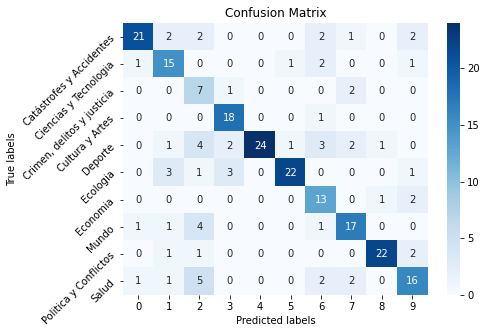

In [14]:
#Evaluar Modelo
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

predicted = model_RF_BOW.predict(X_test)
print('Accuracy: ', accuracy_score(y_test, predicted))
print(classification_report(y_test, predicted))

confusion_matrix = pd.crosstab(predicted, y_test)

fig = plt.figure(figsize=(15,5))
ax = plt.subplot(121)

sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='g')

ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 

ax.set_title('Confusion Matrix'); 

ax.yaxis.set_ticklabels(topics);

plt.yticks(rotation=45)

None

Para comenzar, la regresion logistica con bag of words tiene en general un buen desempeño. El tema de peor desempeño fue 2 (crimen), lo que se podria explicar porque es uno de los temas donde faltaron topicos y se tubo que recurrir a palabras clave, y su dependencia en estas produce bajo recall.

### Regresion logistica IDF

Accuracy:  0.7583333333333333
              precision    recall  f1-score   support

           0       0.78      0.88      0.82        24
           1       0.80      0.67      0.73        24
           2       0.73      0.33      0.46        24
           3       0.95      0.75      0.84        24
           4       0.71      1.00      0.83        24
           5       0.68      0.96      0.79        24
           6       0.78      0.58      0.67        24
           7       0.77      0.71      0.74        24
           8       0.82      0.96      0.88        24
           9       0.67      0.75      0.71        24

    accuracy                           0.76       240
   macro avg       0.77      0.76      0.75       240
weighted avg       0.77      0.76      0.75       240



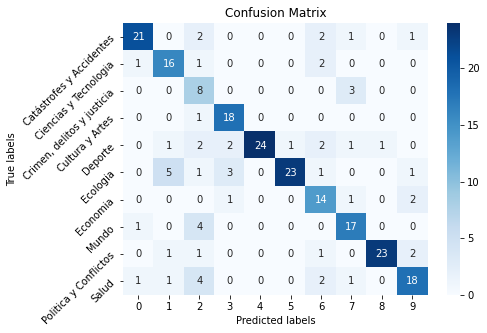

In [15]:
#Evaluar Modelo
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

predicted = model_RF_IDF.predict(X_test)
print('Accuracy: ', accuracy_score(y_test, predicted))
print(classification_report(y_test, predicted))

confusion_matrix = pd.crosstab(predicted, y_test)

fig = plt.figure(figsize=(15,5))
ax = plt.subplot(121)

sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='g')

ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 

ax.set_title('Confusion Matrix'); 

ax.yaxis.set_ticklabels(topics);

plt.yticks(rotation=45)

None

Comparados con RL-BOW, el mayor aumento del f1-score se produce 4(deporte). Esto podria indicar que en noticias deportivas hayan ciertas palabras que tambien son comunes en otras pero se repiten más. Por ejemplo si alguien dice "partido" podría ser una articulo de politica, pero si se repite varias veces es que estan hablando de partidos de futbol por ejemplo. En general su desempeño fue similar.

### Random forest BOW

Accuracy:  0.7833333333333333
              precision    recall  f1-score   support

           0       0.95      0.88      0.91        24
           1       0.68      0.71      0.69        24
           2       0.67      0.50      0.57        24
           3       0.95      0.83      0.89        24
           4       0.65      0.92      0.76        24
           5       0.95      0.88      0.91        24
           6       0.84      0.67      0.74        24
           7       0.78      0.88      0.82        24
           8       0.81      0.88      0.84        24
           9       0.65      0.71      0.68        24

    accuracy                           0.78       240
   macro avg       0.79      0.78      0.78       240
weighted avg       0.79      0.78      0.78       240



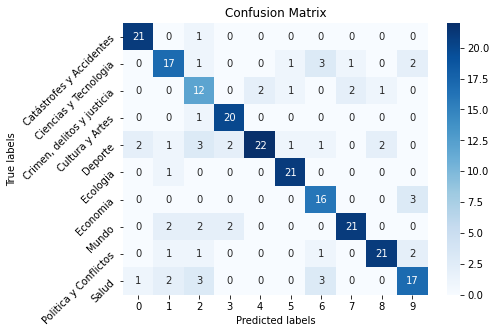

In [16]:
#Evaluar Modelo
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

predicted = model_RL_BOW.predict(X_test)
print('Accuracy: ', accuracy_score(y_test, predicted))
print(classification_report(y_test, predicted))

confusion_matrix = pd.crosstab(predicted, y_test)

fig = plt.figure(figsize=(15,5))
ax = plt.subplot(121)

sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='g')

ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 

ax.set_title('Confusion Matrix'); 

ax.yaxis.set_ticklabels(topics);

plt.yticks(rotation=45)

None

En este caso el algoritmo con random forest presento una mejora por sobre la regresión logistica. Esto podría ser porque los multiples nodos de los arboles se prestan a la clasificación de noticias pues permite considerar un poco la asociación de distintas palabras. Por ejemplo, puede haber un nodo que diga "¿Tiene la palabra partido?" y el nodo siguiente diga "¿Tiene la palabra pelota?" y decir que si dice pelota se refiere a un partido de futbol y si no a un partido político.

### Random forest IDF

Accuracy:  0.8208333333333333
              precision    recall  f1-score   support

           0       1.00      0.92      0.96        24
           1       0.76      0.67      0.71        24
           2       0.69      0.46      0.55        24
           3       0.92      0.92      0.92        24
           4       0.92      0.96      0.94        24
           5       0.74      0.96      0.84        24
           6       0.90      0.79      0.84        24
           7       0.77      0.83      0.80        24
           8       0.82      0.96      0.88        24
           9       0.69      0.75      0.72        24

    accuracy                           0.82       240
   macro avg       0.82      0.82      0.82       240
weighted avg       0.82      0.82      0.82       240



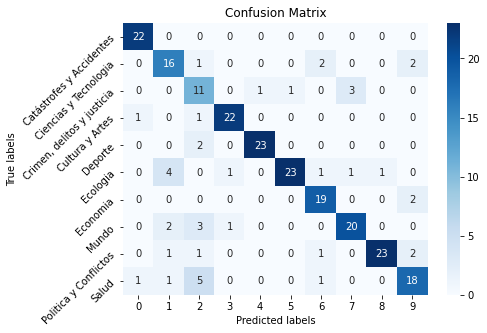

In [17]:
#Evaluar Modelo
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

predicted = model_RL_IDF.predict(X_test)
print('Accuracy: ', accuracy_score(y_test, predicted))
print(classification_report(y_test, predicted))

confusion_matrix = pd.crosstab(predicted, y_test)

fig = plt.figure(figsize=(15,5))
ax = plt.subplot(121)

sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='g')

ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 

ax.set_title('Confusion Matrix'); 

ax.yaxis.set_ticklabels(topics);

plt.yticks(rotation=45)

None

En este caso, considerar las frecuencias de las palabras mejoro el rendimiento del modelo.Esto podría significar que la frecuencia ayuda al bosque a clasificar noticas porque noticias de algun tipo tiendas a repetir más alguna palabra.

### Red Convolucional

In [18]:
preds = torch.zeros(240)
category = torch.zeros(240)
n=0
for batch in test_iterator:
    predictions = model(batch.body)
    max_preds = predictions.argmax(axis=1)
    if(max_preds.shape[0] == 16):
        n= n + 16
        preds[n-16:n] = max_preds
        category[n-16:n] = batch.category
    else:
        n = n + 32
        preds[n-32:n] = max_preds
        category[n-32:n] = batch.category    

Accuracy:  0.7833333333333333
              precision    recall  f1-score   support

         0.0       0.92      0.96      0.94        24
         1.0       0.76      0.67      0.71        24
         2.0       0.62      0.67      0.64        24
         3.0       0.91      0.83      0.87        24
         4.0       0.96      0.96      0.96        24
         5.0       0.77      0.96      0.85        24
         6.0       0.73      0.79      0.76        24
         7.0       0.60      0.50      0.55        24
         8.0       0.88      0.88      0.88        24
         9.0       0.68      0.62      0.65        24

    accuracy                           0.78       240
   macro avg       0.78      0.78      0.78       240
weighted avg       0.78      0.78      0.78       240



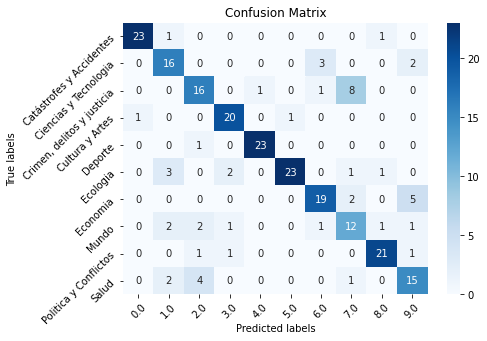

In [19]:
#Evaluar Modelo
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd 

print('Accuracy: ', accuracy_score(preds, category))
print(classification_report(category, preds))

confusion_matrix = pd.crosstab(preds, category)

fig = plt.figure(figsize=(15,5))
ax = plt.subplot(121)

sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='g')

ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 

ax.set_title('Confusion Matrix'); 

ax.yaxis.set_ticklabels(topics);

plt.xticks(rotation=45)
plt.yticks(rotation=45)
None

En general da buenos resultados, de los modelos entrenados hasta ahora solo lo supera el RD con frecuencias. Esto era de esperar por la potencia que suelen tener generalmente las redes neuronales. Tiene problemas para clasficar noticias ciencias, mundo y crimen. En crimen podría ser porque es uno de los temas en los que se tubo que recurrir a keywords, y en ciencias o mundo podria ser porque tiene terminos comunes con otras noticias (pueden haber terminos cientificos en noticias de salud o tecnologia por ejemplo) lo que lleva bajar el score. Finalmente, el rendimiento quiza podría mejorarse con un dataset más grande.